In [1]:
import numpy as np
import os
from tqdm import tqdm
from typing import List, Tuple
from minisom import MiniSom
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

from data import load_dataset

# Implementation Details

Aligned SOMs aims at training mulitple layers of n SOMs with differently weighted subsets of attributes.

The Alignd SOM implementation extends the well known MiniSom package.


## Layer Weighting

Two aspects or concepts of features in a dataset are differently weightet by different layers of the Alignd SOMs. The first layer uses a weighting ratio between aspect A and aspect B features of 1:0. The middle or center layer, weights both aspects equally. The last layer uses a weighting ratio of 0:1.

We create the weights by layer in te **AlignedSom** class using the method **_create_weights_by_layer**. The **AlignedSom** accepts a parameter **concept_indices** which has to be a boolean List inidcating if the feature belongs to aspect A (True or 1) or if it belongs to aspect B (False or 0). 

## Layer inizialization (Orientation / Codebook inizialization)

We create n SOM layers inizializing them  identically using the same common codebook but weighting them by the respective layer weight vector (from 0 for group A attributes and 1 for group B to 0/a for groups A and B in n steps. 

The inizialization of the layers in the **AlignedSom** class is done in the method **_create_layers**. We either crate the common codebook randomly or train the center SOM (trained with unweighted data) and use it as basis for all layer inizializations. This can be changeed by the parameter **initial_codebook_inizialization** ("random" or "pretrained).
The weighting of the layers is done by the **weights_by_layer** as explaind in the previous section. One Layer is represented by the **Layer** class which extends the MiniSom algorithm by overwriting the **update** method.

## Training

We train multiple layers of SOMs iteratively with an online training algorithm.
1) select a random layer and a random observation from the dataset
2) select the winning unit in the selected layer based on the weighted feature vector
3) train all layers updating the weights based on the same winning unint
    * the randomly selected layer is updated as in the normal SOM training
    * all other layers update the weights similarly but the margin of the update is based on the distance to the selected layer
    * all layers use the weighted feature vector based on their respective layer weights
4) iterate steps 1-3 N times

### Layer distances

The distance of the layers is defined as follows.
* the distance to the layer to iteslf is 1.0 -> normal SOM update rule
* the distance to the neighboring layer is a fraction (layer_distance_ratio) of the distance between neighbooring units in one layer (by default 1/10)
* the distance between the first and the last layer is the same distance as the distance of the upper left and lower right unit of each map.
* the distance between all other layers is a linear interploation of the previus two

In [2]:
from typing import Tuple
import numpy as np
from minisom import MiniSom


class Layer(MiniSom):
    def __init__(self,
                 dimension: Tuple[int, int],
                 input_len,
                 initial_codebook,
                 sigma=1,
                 learning_rate=0.5,
                 neighborhood_function='gaussian',
                 activation_distance='euclidean',
                 random_seed=None):
        super().__init__(
            x=dimension[0],
            y=dimension[1],
            input_len=input_len,
            sigma=sigma,
            learning_rate=learning_rate,
            neighborhood_function=neighborhood_function,
            topology='rectangular',
            activation_distance=activation_distance,
            random_seed=random_seed)

        self._weights = initial_codebook

    # changed update to include the distance to the layer in the neighborhood
    # todo: not sure if only winning unit updated or whole neighbourhood for other layers
    def update(self, x, win, layer_dist, t, max_iteration):
        eta = self._decay_function(self._learning_rate, t, max_iteration)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, t, max_iteration)
        # improves the performances
        g = self.neighborhood(win, sig) * eta * layer_dist
        # w_new = eta * neighborhood_function * (x-w)
        self._weights += np.einsum('ij, ijk->ijk', g, x-self._weights)

In [3]:
class AlignedSom(MiniSom):
    def __init__(self,
                 dimension: Tuple[int, int],
                 data: np.ndarray,  # 2d numpy array
                 concept_indices: List[bool],  # boolean list if feature belongs to concept A or concept B
                 num_layers: int = 100,
                 layer_distance_ratio: float = 0.1,
                 sigma: float = 1.0,
                 learning_rate: float = 0.5,
                 neighborhood_function: str = 'gaussian',
                 activation_distance: str = 'euclidean',
                 initial_codebook_inizialization: str = 'random',  # random or pretrained
                 random_seed=None):
        super().__init__(
            x=dimension[0],
            y=dimension[1],
            input_len=data.shape[1],
            sigma=sigma,
            learning_rate=learning_rate,
            neighborhood_function=neighborhood_function,
            topology='rectangular',
            activation_distance=activation_distance,
            random_seed=random_seed)
        self.data = data
        self.dimension = dimension
        self.concept_indices = concept_indices
        self.num_layers = num_layers
        self.layer_distance_ratio = layer_distance_ratio
        self._neighborhood_function = neighborhood_function
        self._initial_codebook_inizialization = initial_codebook_inizialization
        self.random_seed = random_seed

        self.weights_by_layer: np.ndarray = self._create_weights_by_layer()
        self.layers: List[Layer] = self._create_layers()
        self.layer_distances = self._create_layer_distances()

    def train(self,
              data: np.ndarray,  # 2d numpy array,
              num_iterations):
        n_observations = data.shape[0]
        for t in tqdm(range(num_iterations)):
            selected_layer = randrange(0, self.num_layers)
            selected_observation = randrange(0, n_observations)
            # print(f'selected layer: {selected_layer}')
            # print(f'selected observation: {selected_observation}')
            winner = self.layers[selected_layer].winner(
                data[selected_observation] * self.weights_by_layer[selected_layer])
            for i, layer in enumerate(self.layers):
                # print(f'current layer: {i}')
                # ĺayer_dist = self.layer_distance(t, num_iterations, np.abs(selected_layer - i))
                ĺayer_dist = self.layer_distances[np.abs(selected_layer - i)]
                # print(f'distance: {ĺayer_dist}')
                layer.update(data[selected_observation] * self.weights_by_layer[i],
                             winner,
                             ĺayer_dist,
                             t,
                             num_iterations)

    # the distance between one layer and the next is defined by the distance between neighboring units
    # multiplyed by some fraction "layer_distance_ratio"
    def layer_distance(self, t, max_iteration, grid_distance):
        if grid_distance == 0.0:
            return 1.0
        sig = self._decay_function(self._sigma, t, max_iteration)
        distance_neighboring_units = self.neighborhood((0, 0), sig)[(0, 1)]
        return distance_neighboring_units * (self.layer_distance_ratio / grid_distance)

    # return the codebook weights for all layers
    def get_layer_weights(self) -> List[np.ndarray]:
        return [layer.get_weights() for layer in self.layers]
    
    # load the codebook weights for all layers
    def set_layer_weights(self, weights_by_layer: np.ndarray):
        layers = []
        for weights in weights_by_layer:
            layers.append(Layer(
                dimension=self.dimension,
                input_len=self._input_len,
                initial_codebook=np.array(weights, dtype=np.float32),
                sigma=self._sigma,
                learning_rate=self._learning_rate,
                neighborhood_function=self._neighborhood_function,
                activation_distance=self._activation_distance,
                random_seed=self.random_seed))
        self.layers = layers
       
    
    def _create_layer_distances(self):
        # used default gaussian with sigma = 1.0 for distance between layers
        x_mash, y_mash = np.meshgrid(np.arange(1), np.arange(self.num_layers - 1))
        d = 2
        ax = np.exp(-np.power(x_mash-x_mash[0], 2)/d)
        ay = np.exp(-np.power(y_mash-y_mash[0], 2)/d)
        layer_distances = (ax * ay).T[0]
        layer_distances *= self.layer_distance_ratio
        layer_distances = np.insert(layer_distances, 0, 1.0)  # distence to layer itself
        return layer_distances
    
    def _gaussian_for_layer(c, sigma):
        d = 2
        ax = np.exp(-np.power(aa-aa[c], 2)/d)
        ay = np.exp(-np.power(bb-bb[c], 2)/d)
        return (ax * ay).T  # the external product gives a matrix    

    # create a weights matrix for two concepts in a feature matrix
    # the shape corresponds to shape (num_layers, input_len))
    # where num_soms is the number of soms trained
    def _create_weights_by_layer(self):
        if self.concept_indices.shape[0] != self._input_len:
            raise AttributeError('concept_indices has to have the same dimension as input_len')
        column_weights = []
        weights_concept_1 = np.linspace(0, 1, self.num_layers)
        weights_concept_2 = np.linspace(1, 0, self.num_layers)
        for i in self.concept_indices:
            if i:
                column_weights.append(weights_concept_1)
            else:
                column_weights.append(weights_concept_2)
        return np.column_stack(column_weights)

    # initialize all layers of the aligned SOM
    def _create_layers(self) -> List[Layer]:
        layers = []
        if self._initial_codebook_inizialization == 'random':
            inital_weights = self._create_random_weights()
        elif self._initial_codebook_inizialization == 'pretrained':
            inital_weights = self._create_weights_by_training_one_some()
        else:
            raise AttributeError('initial_codebook_inizialization has to be "random" or "pretrained"')
        for weights in self.weights_by_layer:
            layers.append(Layer(
                dimension=self.dimension,
                input_len=self._input_len,
                initial_codebook=np.array(inital_weights * weights, dtype=np.float32),
                sigma=self._sigma,
                learning_rate=self._learning_rate,
                neighborhood_function=self._neighborhood_function,
                activation_distance=self._activation_distance,
                random_seed=self.random_seed))
        return layers

    def _create_random_weights(self):
        if self.random_seed:
            np.random.seed(self.random_seed)
        return np.random.random((self.dimension[0], self.dimension[1], self._input_len))

    def _create_weights_by_training_one_some(self):
        # som trained on not weighted features (same as middle layer)
        middle_som = MiniSom(
            x=self.dimension[0],
            y=self.dimension[1],
            input_len=self._input_len,
            sigma=self._sigma,
            learning_rate=self._learning_rate,
            neighborhood_function=self._neighborhood_function,
            topology='rectangular',
            activation_distance=self._activation_distance,
            random_seed=self.random_seed)
        middle_som.train(self.data, 1000)
        return middle_som.get_weights()


In [4]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata, upscaling_factor=1000):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1
    
    hist_reshaped = hist.reshape(_m, _n)
    return resize(hist_reshaped, (upscaling_factor, upscaling_factor), mode='constant')

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim, upscaling_factor=1000):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)
    return resize(U, (upscaling_factor, upscaling_factor), mode='constant')
    #return U


#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor=2, approach=0, upscaling_factor=1000):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)
    
    sdh_m = sdh_m.reshape(_m, _n)
    return resize(sdh_m, (upscaling_factor, upscaling_factor), mode='constant')


In [5]:
def plot_aligned_som(asom: AlignedSom, data:np.ndarray, visualization_function=SDH, num_plots=5, value_range=(0,5), **kwargs):
    """Plot the aligned SOM

    Args:
        asom (AlignedSom): trained aligned SOM to plot
        data (np.ndarray): input data to use for the visualization
        visualization_function (Callable, optional): Which visualization to use. Options are: SDH, HitHist and UMatrix. Defaults to SDH.
        num_plots (int, optional): How many intermediary plots to show. Defaults to 5.
        value_range (tuple, optional): Value range of the histogram given as tuple of min and max values. Defaults to (0,5).
        kwargs: Additional arguments to pass to the visualization function
    
    Returns:
        matplotlib figure: Figure object_
    """
    assert num_plots <= asom.num_layers, "Number of plots must be less than or equal to the number of layers"
    
    # calculate the histograms
    visualizations = []
    for layer_weights in asom.get_layer_weights():
        layer_weights = np.reshape(layer_weights, (asom.dimension[0] * asom.dimension[1], data.shape[1]))
        if visualization_function == UMatrix:
            histogram = visualization_function(asom.dimension[0], asom.dimension[1], layer_weights, data.shape[1], **kwargs)
        else:
            histogram = visualization_function(asom.dimension[0], asom.dimension[1], layer_weights, data, **kwargs)
        visualizations.append(histogram)
    
    # decrease figure size to increase plotting speed for larger plots
    if num_plots > 32:
        figsize = (0.75*num_plots, 0.6125)
    if num_plots > 16:
        figsize = (1.5*num_plots, 1.25)
    elif num_plots > 8:
        figsize = (3*num_plots, 2.5)
    else:
        figsize=(6*num_plots,5)
    
    # create the plot
    figure, axis = plt.subplots(1, num_plots, figsize=figsize)
    for i, vis_i in enumerate(np.linspace(0, asom.num_layers - 1, num_plots, dtype=int)):
        hp = sns.heatmap(visualizations[vis_i], ax=axis[i], vmin=value_range[0], vmax=value_range[1], cbar=False, cmap='viridis')
        hp.set(xticklabels=[])
        hp.set(yticklabels=[])
        axis[i].tick_params(left=False, bottom=False)
        hp.set(xlabel=f"Weigh: {asom.weights_by_layer[vis_i][0]} - {asom.weights_by_layer[vis_i][1]}")
    plt.show()
    return figure

# Setup Below

In [6]:
TRAIN_STEPS = 1000

# 10 Clusters 100x60 

## Default Setup

In [ ]:
def setup(SOM_DIM = (100, 60), N_LAYERS=31, sigma=1.0, concept_indices=[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], layer_distance_ratio=0.1, learning_rate=0.5, num_plots=5, load_existing=True):
    SEED = 12345

    input_data, components, weights, classinfo = load_dataset('10clusters')
    data = input_data['arr']
    concept_indices = np.array(concept_indices)
   
    asom = AlignedSom(
        SOM_DIM, data, concept_indices,
        num_layers=N_LAYERS,
        sigma=sigma,
        learning_rate=learning_rate,
        layer_distance_ratio=layer_distance_ratio,
        initial_codebook_inizialization='random')
    
    os.makedirs("../results", exist_ok=True)
    
    if load_existing and os.path.exists(f"../results/10clusters_setup_{SOM_DIM[0]}_{SOM_DIM[1]}_{N_LAYERS}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in concept_indices])}.npy"):
        asom.set_layer_weights(np.load(f"../results/10clusters_setup_{SOM_DIM[0]}_{SOM_DIM[1]}_{N_LAYERS}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in concept_indices])}.npy"))
    else:
        asom.train(data, TRAIN_STEPS * N_LAYERS)
        np.save(f"../results/10clusters_setup_{SOM_DIM[0]}_{SOM_DIM[1]}_{N_LAYERS}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in concept_indices])}.npy", np.array(asom.get_layer_weights()))
    
    fig = plot_aligned_som(asom, data, num_plots=num_plots, upscaling_factor=100)
    fig.savefig(f"../results/10clusters_setup_{SOM_DIM[0]}_{SOM_DIM[1]}_{N_LAYERS}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in concept_indices])}.pdf")
    
    return data, asom


In [ ]:
data_large_1, asom_large_1 = setup()

100%|██████████| 31000/31000 [15:06<00:00, 34.19it/s]


TypeError: sequence item 0: expected str instance, numpy.int64 found

## Many In-Between Layers

In [ ]:
data_large_2, asom_large_2 = setup(N_LAYERS=128)

## Strong Layer-Wise Coupling

In [ ]:
data_large_3, asom_large_3 = setup(layer_distance_ratio=10)

## Weak Layer-Wise Coupling

In [ ]:
data_large_4, asom_large_4 = setup(layer_distance_ratio=1e-3)

## Few In-Between Layers

In [ ]:
data_large_5, asom_large_5 = setup(N_LAYERS=6)

## Switch Concept Indices

In [ ]:
data_large_6, asom_large_6 = setup(concept_indices=[0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

## Only Attribute A

In [ ]:
data_large_7, asom_large_7 = setup(concept_indices=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Only Attribute B

In [ ]:
data_large_8, asom_large_8 = setup(concept_indices=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# 10 Clusters 10x10

100%|██████████| 31000/31000 [00:52<00:00, 588.12it/s]


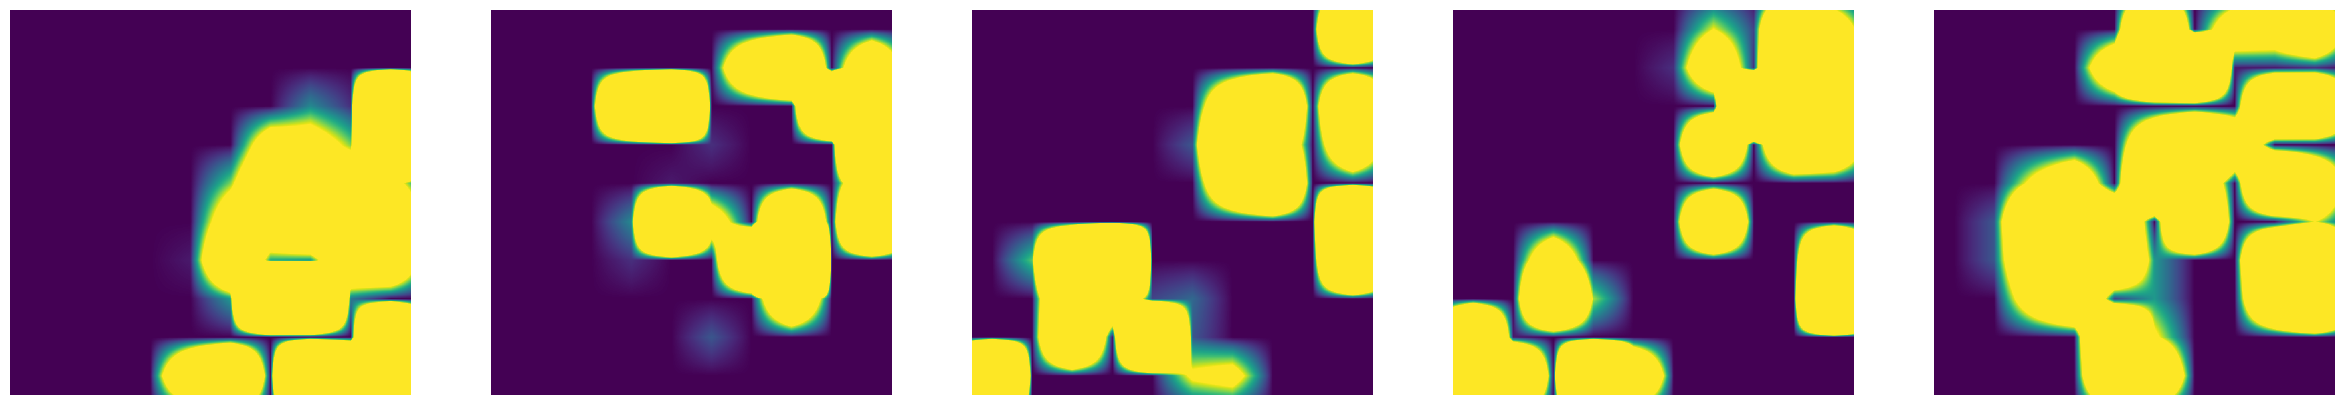

100%|██████████| 128000/128000 [15:43<00:00, 135.69it/s]


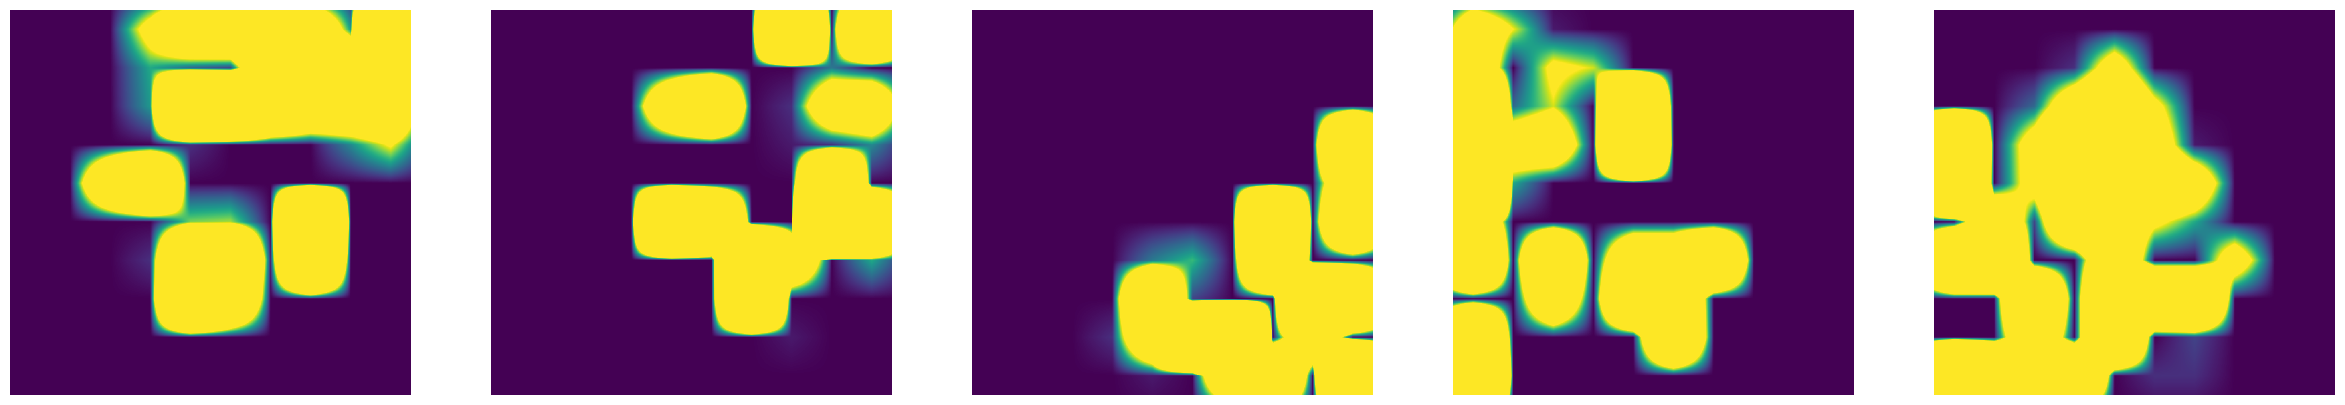

In [11]:
## Default Setup
data_small_1, asom_small_1 = setup(SOM_DIM = (100, 60))
## Many In-Between Layers
data_small_2, asom_small_2 = setup(SOM_DIM = (100, 60), N_LAYERS=128)
## Strong Layer-Wise Coupling
data_small_3, asom_small_3 = setup(SOM_DIM = (100, 60), layer_distance_ratio=10)
## Weak Layer-Wise Coupling
data_small_4, asom_small_4 = setup(SOM_DIM = (100, 60), layer_distance_ratio=1e-3)
## Few In-Between Layers
data_small_5, asom_small_5 = setup(SOM_DIM = (100, 60), N_LAYERS=6)

Vary learnign rate, sigma, which features are attribute A and which B number of layers